# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd

pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=np.nan)


## Setup

* Setup path vars
* get competition data
* download encoder weights and int-string mapping for language model pretrained on wikipedia

In [2]:
DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./language_model_wiki/LM')

TWEETSLM_PATH=Path('./LM_tweets')

CLAS_PATH=Path('./tweets_class')

(TWEETSLM_PATH).mkdir(exist_ok=True)
(CLAS_PATH).mkdir(exist_ok=True)

In [3]:
gdd.download_file_from_google_drive(file_id='1WG9od7fYgN4XHpyBJxlRrlQDW8iXMeo3',
                                    dest_path='./Data+Model_ULMFit_es.tar.gz',
                                    unzip=False)

In [4]:
! tar -xvzf Data+Model_ULMFit_es.tar.gz 
! rm -rf    Data+Model_ULMFit_es.tar.gz 

! mkdir  --parents {DATA_PATH}
! mv Data+Model_ULMFit_es/corpus_completo_5_temas_08-sep-2016-codificacion_5_temas.csv {DATA_PATH}

! mkdir --parents {WIKILM_PATH/'models'}
! mv Data+Model_ULMFit_es/lm1_weights.h5 {WIKILM_PATH/'models'}

! mkdir --parents {WIKILM_PATH/'tmp'}
! mv Data+Model_ULMFit_es/itos.pkl {WIKILM_PATH/'tmp'}

! rm -rf Data+Model_ULMFit_es

!python -m spacy download es

Data+Model_ULMFit_es/
Data+Model_ULMFit_es/itos.pkl
Data+Model_ULMFit_es/corpus_completo_5_temas_08-sep-2016-codificacion_5_temas.csv
Data+Model_ULMFit_es/lm1_weights.h5

    Linking successful
    /home/andreas/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/es_core_news_sm
    -->
    /home/andreas/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/spacy/data/es

    You can now load the model via spacy.load('es')



## Fintune  

In [3]:
df = pd.read_csv(DATA_PATH/'corpus_completo_5_temas_08-sep-2016-codificacion_5_temas.csv')

In [4]:
print(df.shape)
print(df.columns.values)
print(df['Texto'].isnull().any())
print(df['Tema_05'].isnull().any())
print(df['Tema_05'].value_counts())

(3116, 5)
['Num' 'Id Tweet' 'Fecha Publicacion' 'Texto' 'Tema_05']
False
False
2     1102
1     738 
9     718 
11    359 
10    199 
Name: Tema_05, dtype: int64


In [5]:
# encode lables
df['Tema_05'] = df['Tema_05'].replace([2, 1, 9, 11, 10], [0, 1, 2, 3, 4])
print(df['Tema_05'].value_counts())

0    1102
1    738 
2    718 
3    359 
4    199 
Name: Tema_05, dtype: int64


#### Upsample to balance dataset

In [6]:
#lst = [df]
#max_size = df['Tema_05'].value_counts().max()
#for class_index, group in df.groupby('Tema_05'):
    #lst.append(group.sample(max_size-len(group), replace=True))
#df = pd.concat(lst)
#print(df['Tema_05'].value_counts())

In [7]:
tweets = df['Texto'].values
labels = df['Tema_05'].values
LABELS = set(labels)

In [8]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets, labels):
    """
    twitter specific text processing and shuffle
    """
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@') 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for Hashtags
    tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que', 'slang_string'] if i=='q' else ['por', 'slang_string'] if i=='x' else ['de', 'slang_string'] if i=='d' else ['Que', 'slang_string'] if i=='Q' else ['Por', 'slang_string'] if i=='X' else ['De', 'slang_string'] if i=='D' else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    #shuffle
    np.random.seed(42)
    trn_idx = np.random.permutation(len(tweets))
    tweets = tweets[trn_idx]
    labels = labels[trn_idx]
    
    return tweets, labels



In [9]:
tweets, labels = preprocess_tweets(tweets, labels)

In [10]:
col_names = ['label', 'tweet']

In [11]:
print(tweets[:15])

['RT user_ref user_ref user_ref user_ref Otro ejemplo de LLENO hyp_link'
 'AIIII QUE ME DA JAJAJJAJAAJAJAJA hyp_link TWEET CITADO: JAJAJAJAJAJAJAJAJAJAJAJA estoy llorando de risa, y mucho user_ref user_ref user_ref hyp_link'
 'Así debería ser, pero ahora con salir en cualquier programa de tv haciendo el chorra parece suficiente. hyp_link TWEET CITADO: El trabajo principal de los políticos es estar con sus ciudadanos. Seguro que no es la última vez que nos vemos ;) hyp_link'
 'RT user_ref hash_tag #ELPAISDebate user_ref recuerda al candidato de Podemos que fue imputado por agredir a un edil socialista hyp_link'
 'Cada vez que Rajoy diga "Eeeeh..." chupito. Moraso seguro.'
 'Iglesias alerta al PSOE contra la gran coalición y le insta a reconocer la "plurinacionalidad" del Estado hyp_link'
 'RT user_ref - En las imágenes se aprecia que user_ref consume estupefacientes y que... Cambia las fotos, coño. ¡Las fotos! ht…'
 'RT user_ref A partir de las 20:30, entrevista a la candidata por el ha

In [12]:
train_limit = int(len(tweets)*0.8)

In [13]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:], 'label':labels[train_limit:]}, columns=col_names)
#df_tst = pd.DataFrame({'tweet':tweets[val_limit:], 'label':labels[val_limit:]}, columns=col_names)

In [14]:
df_trn.head(15)

,label,tweet
0,2,RT user_ref user_ref user_ref user_ref Otro ejemplo de LLENO hyp_link
1,3,"AIIII QUE ME DA JAJAJJAJAAJAJAJA hyp_link TWEET CITADO: JAJAJAJAJAJAJAJAJAJAJAJA estoy llorando de risa, y mucho user_ref user_ref user_ref hyp_link"
2,0,"Así debería ser, pero ahora con salir en cualquier programa de tv haciendo el chorra parece suficiente. hyp_link TWEET CITADO: El trabajo principal de los políticos es estar con sus ciudadanos. Seguro que no es la última vez que nos vemos ;) hyp_link"
3,0,RT user_ref hash_tag #ELPAISDebate user_ref recuerda al candidato de Podemos que fue imputado por agredir a un edil socialista hyp_link
4,4,"Cada vez que Rajoy diga ""Eeeeh..."" chupito. Moraso seguro."
5,1,"Iglesias alerta al PSOE contra la gran coalición y le insta a reconocer la ""plurinacionalidad"" del Estado hyp_link"
6,4,"RT user_ref - En las imágenes se aprecia que user_ref consume estupefacientes y que... Cambia las fotos, coño. ¡Las fotos! ht…"
7,2,"RT user_ref A partir de las 20:30, entrevista a la candidata por el hash_tag #PSOE user_ref en Canal Sur user_ref no te la pierdas! hyp_link"
8,2,RT user_ref ¡¡Gracias a todos por hacer hash_tag #RiveraEH 1TT Mundial!! 👏👏 hyp_link vía user_ref ¡Buenas noches!
9,0,RT user_ref El PP apuesta por reforzar la cohesión territorial hyp_link vía user_ref


In [15]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
#df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

In [16]:
df_trn = pd.DataFrame({'tweet':tweets[:train_limit], 'label':[0]*len(labels[:train_limit])}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets[train_limit:], 'label':[0]*len(labels[train_limit:])}, columns=col_names)

In [17]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [18]:
df_trn.shape, df_val.shape

((2492, 2), (624, 2))

## Tokenize and Standarize General Tokens for TASS Dataset


In [19]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [20]:
chunksize=24000

re1 = re.compile(r'  +')

In [21]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [22]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [23]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [24]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(2492, 2492, 624, 624)

In [25]:
print(tok_trn[:2])

[['\n', 'xbos', 'rt', 'tk_wrep', '4', 'user_ref', 'otro', 'ejemplo', 'de', 't_up', 'lleno', 'hyp_link'], ['\n', 'xbos', 'a', 'tk_rep', '4', 'i', 't_up', 'que', 'me', 'da', 't_up', 'jajajjajaajajaja', 'hyp_link', 't_up', 'tweet', 't_up', 'citado', ':', 't_up', 'jajajajajajajajajajajaja', 'estoy', 'llorando', 'de', 'risa', ',', 'y', 'mucho', 'user_ref', 'user_ref', 'user_ref', 'hyp_link']]


In [26]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [27]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [29]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('user_ref', 3220),
 ('\n', 2492),
 ('xbos', 2492),
 ('t_up', 1914),
 ('de', 1837),
 ('hyp_link', 1801),
 ('#', 1748),
 ('hash_tag', 1735),
 ('rt', 1717),
 ('el', 1432),
 ('que', 1192),
 ('la', 1164),
 ('.', 1155),
 ('a', 1139),
 (',', 1064),
 ('y', 971),
 ('en', 967),
 ('"', 869),
 (':', 688),
 ('no', 617)]

In [30]:
max_vocab = 60000
min_freq = 2

In [31]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

1805

In [32]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [33]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [34]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights.h5'

In [35]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [36]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [37]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [38]:
em_sz,nh,nl = 400,1150,3

In [39]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [40]:
vs=len(itos)
vs,len(trn_lm)

(1805, 2492)

In [41]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [42]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [43]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [44]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [45]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [46]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [47]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [48]:
learn.model.load_state_dict(wgts)

In [51]:
learn.lr_find2(start_lr=1e-1,end_lr=.7, num_it=300)

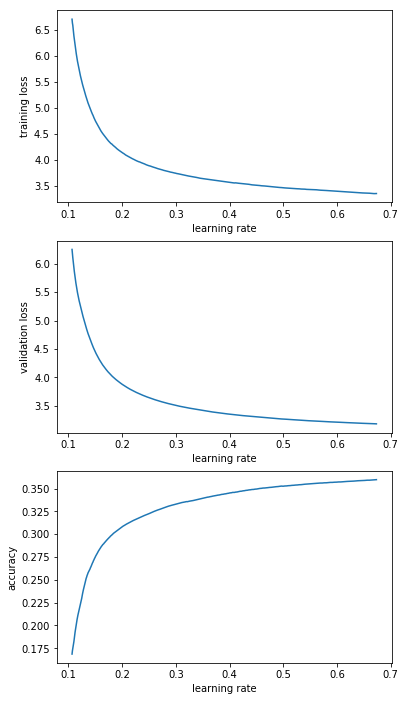

In [52]:
learn.sched.plot()

In [53]:
lr= .18
lrs = lr

In [54]:
learn.clip=0.12

In [56]:
learn.fit(lr, 2, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                
    0      4.603168   4.36997    0.293694  
    1      4.526901   4.198717   0.296976                 
    2      4.427967   3.995069   0.307995                 
    3      4.308413   3.898955   0.30675                  
    4      4.215509   3.784937   0.315341                 
    5      4.133605   3.739435   0.318614                 
    6      4.074616   3.712009   0.321223                 
    7      4.031208   3.706035   0.322434                 
    8      3.995183   3.702918   0.323295                
    9      3.967034   3.69747    0.324464                 
    10     3.946594   3.663322   0.322559                 
    11     3.922107   3.627618   0.324443                 
    12     3.890753   3.568183   0.329706                 
    13     3.855915   3.539736   0.327367                 
    14     3.823054   3.505982   0.332508                 
    15     3.797799   3.488113   0.33443                 
    16     3.76

[array([3.46744]), 0.33630952185818125]

In [57]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [58]:
chunksize=24000

re1 = re.compile(r'  +')

In [59]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)

In [60]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [61]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [62]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

In [63]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [64]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [65]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

1805

In [66]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [67]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [68]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [69]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [70]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [71]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [72]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [73]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8

In [74]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [75]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [76]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [84]:
lr= .0015
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [85]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [86]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [87]:
learn.freeze_to(-1)

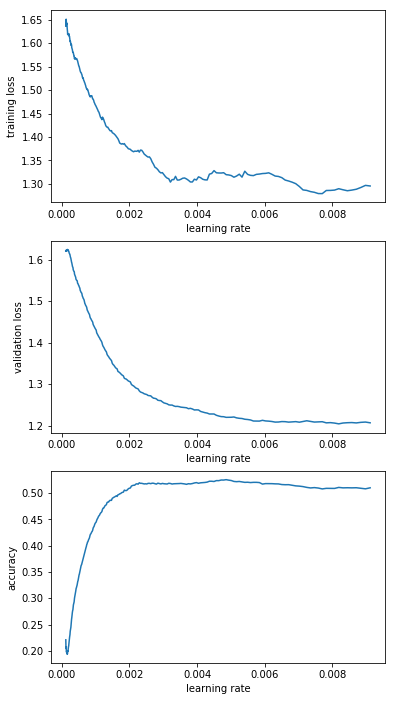

In [81]:
learn.lr_find2(start_lr=1e-4,end_lr=1e-2, num_it=300)
learn.sched.plot()

In [89]:
learn.fit(lrs, 3, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                 
    0      1.248761   1.139196   0.512394  
    1      1.231794   1.132416   0.54374                  
    2      1.216401   1.103186   0.567178                 


[array([1.10319]), 0.5671778564099912]

In [90]:
learn.save('clas2_0')

In [91]:
learn.load('clas2_0')

In [92]:
learn.freeze_to(-2)

In [95]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7))

epoch      trn_loss   val_loss   accuracy                 
    0      1.106903   1.048164   0.586323  


[array([1.04816]), 0.5863233117593659]

In [96]:
learn.save('clas2_1')

In [97]:
learn.load('clas2_1')

In [98]:
learn.unfreeze()

In [100]:
learn.fit(lr, 1, cycle_len=8, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2')

epoch      trn_loss   val_loss   accuracy                  
    0      0.314664   0.957308   0.668933  
    1      0.308399   0.968091   0.667486                  
    2      0.292085   1.059155   0.669174                  
    3      0.282105   1.087047   0.681327                  
    4      0.259322   1.107726   0.689091                  
    5      0.231831   1.148725   0.687355                  
    6      0.197698   1.124139   0.668885                  
    7      0.190414   1.148154   0.67501                   


[array([1.14815]), 0.6750096433140613]

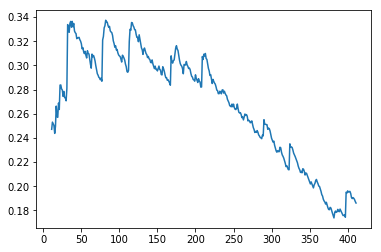

In [101]:
learn.sched.plot_loss()

In [102]:
learn.save('final')

## Model Evaluation

In [103]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1(macro) =  0.6379956300855912
Accuracy  =  0.6698717948717948


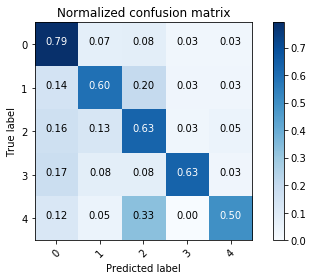

In [104]:
from fastai.text import *
from fastai.lm_rnn import *
from sklearn.metrics import f1_score, confusion_matrix

bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

val_sent = np.load(CLAS_PATH/'tmp/val_ids.npy')
val_lbls = np.load(CLAS_PATH/'tmp/val_labels.npy').flatten()
val_lbls -= val_lbls.min()
c=int(val_lbls.max())+1
val_ds = TextDataset(val_sent, val_lbls)
val_samp = SortSampler(val_sent, key=lambda x: len(val_sent[x]))
val_lbls_sampled = val_lbls[list(val_samp)]
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, None, val_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(val_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (val_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(val_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.unique(val_lbls), normalize=True,
                      title='Normalized confusion matrix')
plt.show()